# GMM - Dataset Sintético

En éste notebook, vamos a usar el modelo de GMM desarrollado en NumPy usando Expectation Maximization y el dataset sintético armado, para evaluar el algoritmo y compararlo con K-means.

## Cargamos las Librerías

In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import sys
sys.path.append('..')
from utils.models import BaseModel
from utils.metrics import Accuracy, Precision, Recall
from utils.EM_Numpy import EMScalar
from utils.kmeans import KMeans
from data.SyntheticDataset import SyntheticDataset

## Cargamos el Dataset

In [3]:
# Creamos el dataset

# Establecemos los parámetros de las GMM
mu = np.array([5, 10])
var = np.array([15, 2])
p = 0.25

dataset = SyntheticDataset(mu, var, p, 500)
x_train, x_test, y_train, y_test = dataset.split(0.8)

In [4]:
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

## Cargamos los Modelos

In [5]:
# Model fit y predict

EM = EMScalar()
EM.fit(x_train, 2)
predictions = EM.predict(x_test)

In [6]:
print("Expectation Maximization\n")

print("Means: ")
print(EM.model['mu'], "\n")

print("Covariance: ")
print(EM.model['cov'], "\n")

print("Probabilities: ")
print(EM.model['p'], "\n")

metrics = [Precision, Accuracy, Recall]

for metric in metrics:
    aux = metric(truth=y_test, predictions=predictions)
    print('{}: {}'.format(metric.__class__.__name__, aux()))

Expectation Maximization

Means: 
[[ 7.23522046]
 [10.09441889]] 

Covariance: 
[[195.92717361]
 [  3.74237473]] 

Probabilities: 
[[0.2671975 ]
 [0.73280243]] 

type: 0.925
type: 0.898876404494382
type: 0.961038961038961


# Comparamos los resultados con K-means



In [7]:
k_means = KMeans(n_clusters=2, max_iter=10)
model = k_means.fit(x_train)

In [8]:
centers = model.cluster_centers_
ids = model.labels_

In [9]:
k_predictions = model.predict(x_test)

In [10]:
print("K-means")

k_predictions = np.where((k_predictions==0)|(k_predictions==1), k_predictions^1, k_predictions)

for metric in metrics:
    aux = metric(truth=y_test, predictions=k_predictions)
    print('{}: {:.2f}'.format(metric.__class__.__name__, aux()))

K-means
type: 0.85
type: 0.87
type: 1.00


### Gráficas

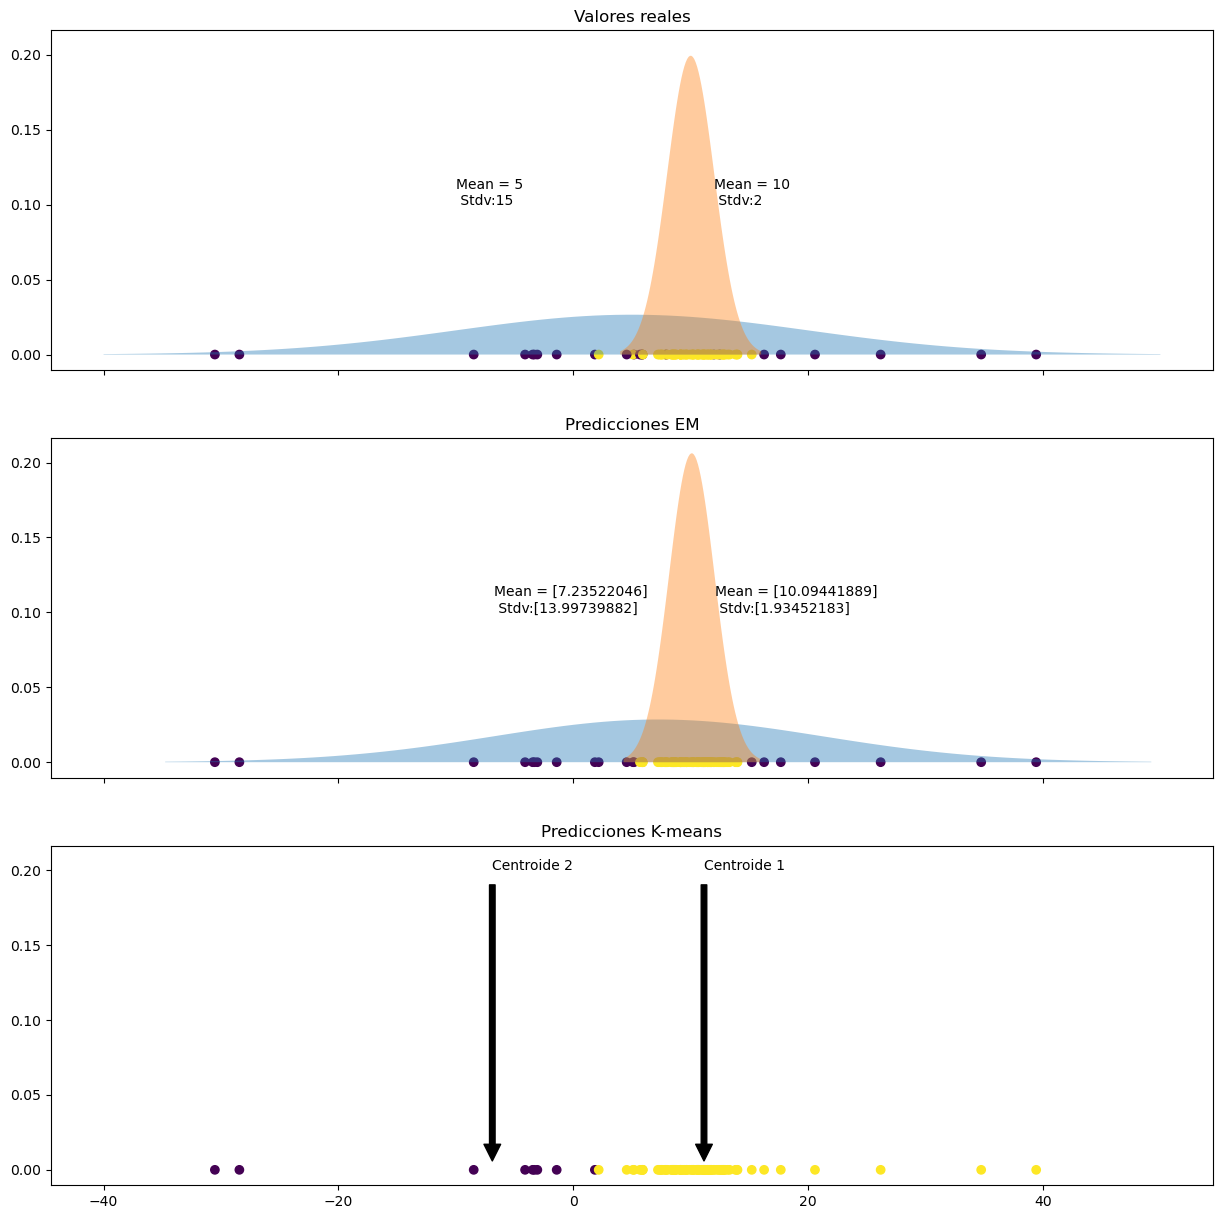

In [11]:
# Plots
mpl.rc_file_defaults()
f, (ax, bx, cx) = plt.subplots(3, 1, sharey='col', sharex='col', figsize=(15, 15))

ax.scatter(x_test[:, 0], np.zeros_like(x_test), c=y_test, alpha=1)
xr_1 = np.linspace(mu[0] - 3 * var[0], mu[0] + 3 * var[0], 100)
xr_2 = np.linspace(mu[1] - 3 * var[1], mu[1] + 3 * var[1], 100)
density_r1 = norm.pdf(xr_1, loc=mu[0], scale=var[0])
density_r2 = norm.pdf(xr_2, loc=mu[1], scale=var[1])
ax.fill_between(xr_1, density_r1, alpha=0.4)
ax.fill_between(xr_2, density_r2, alpha=0.4)
ax.text(mu[0] - 1 * var[0], 0.1, 'Mean = {media}\n Stdv:{std}'.format(media=mu[0], std=var[0]))
ax.text(mu[1] + 1 * var[1], 0.1, 'Mean = {media}\n Stdv:{std}'.format(media=mu[1], std=var[1]))
ax.set_title('Valores reales')

bx.scatter(x_test[:, 0], np.zeros_like(x_test), c=predictions, alpha=1)
x_1 = np.linspace(EM.model['mu'][0] - 3 * (EM.model['cov'][0] ** 0.5),
                  EM.model['mu'][0] + 3 * (EM.model['cov'][0] ** 0.5), 100)
x_2 = np.linspace(EM.model['mu'][1] - 3 * (EM.model['cov'][1] ** 0.5),
                  EM.model['mu'][1] + 3 * (EM.model['cov'][1] ** 0.5), 100)
density_1 = norm.pdf(x_1[:, 0], loc=EM.model['mu'][0], scale=EM.model['cov'][0] ** 0.5)
density_2 = norm.pdf(x_2[:, 0], loc=EM.model['mu'][1], scale=EM.model['cov'][1] ** 0.5)
bx.fill_between(x_1[:, 0], density_1, alpha=0.4)
bx.fill_between(x_2[:, 0], density_2, alpha=0.4)
bx.set_title('Predicciones EM')
bx.text(EM.model['mu'][0] - 1 * EM.model['cov'][0] ** 0.5, 0.1,
        'Mean = {media}\n Stdv:{std}'.format(media=EM.model['mu'][0], std=EM.model['cov'][0] ** 0.5))
bx.text(EM.model['mu'][1] + 1 * EM.model['cov'][1] ** 0.5, 0.1,
        'Mean = {media}\n Stdv:{std}'.format(media=EM.model['mu'][1], std=EM.model['cov'][1] ** 0.5))

cx.scatter(x_test[:, 0], np.zeros_like(x_test), c=k_predictions, alpha=1)
cx.set_title('Predicciones K-means')
cx.annotate('Centroide 1', xy=(centers[0], 0), xytext=(centers[0], 0.2),
            arrowprops=dict(facecolor='black', shrink=0.03))
cx.annotate('Centroide 2', xy=(centers[1], 0), xytext=(centers[1], 0.2),
            arrowprops=dict(facecolor='black', shrink=0.03))

plt.show()
